**Siamese Network for face recognition**

Given two images, the model will predict whether the two persons are same or not

Author: Venkatesan Krishnamurthy



**Loading the essential libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.activations import relu
from tensorflow.keras import backend as K
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#!tar -xvf  '/content/drive/MyDrive/lfw-funneled.tgz' -C '/content/drive/MyDrive/Siamese_Images' # extract images from tgz to google drive

**Extracting details and images from the directories**

In [ ]:
# Create a dictionary of classes from the folder names. 
class_dict = {}

dir_list = [] # list with only names of the folder
dir_with_root_list = [] # list with the full paths for each folder
for root, dirs, files in os.walk("/content/drive/MyDrive/Siamese_Images/lfw_funneled", topdown=False): # Getting only the names of the folders, ignoring the text files
    for name in dirs:
        dir_list.append(name)
        dir_with_root_list.append(os.path.join(root, name))

dir_list.sort()
dir_with_root_list.sort()
for num in range(len(dir_list)):
  class_dict[num] = dir_list[num]  # acts as a reference dict. For a given number, it will give us the name of the class ("person") eg: class_dict = {0: 'Richard_Jefferson',...}

In [ ]:
"""
# Read in all the images and save their classes
img_list = []
class_list = []

for label in range(0, len(dir_with_root_list)):                                   # list of folders. Each folder has one or more images of one person 
  for root, dirs, files in os.walk(dir_with_root_list[label], topdown=False):     # Get inside one folder
    for file in files:                                                            # for all the files in that one folder,
      class_list.append(label)                                                    # give the same label
      img = plt.imread(os.path.join(root,file))                                   # and read all those images in one folder
      img_list.append(img)
"""
# The above process has been saved into arrays for faster re-loading. 
img_array = np.load("/content/drive/MyDrive/Siamese_Images/img_list_array.npy")      # An array of all images (13233, 250, 250, 3)
class_array = np.load("/content/drive/MyDrive/Siamese_Images/class_list_array.npy") # An array of class numbers for the respective images. (13233,)

**Resizing and Normalising Images**

Text(0.5, 1.0, 'Adrien_Brody')

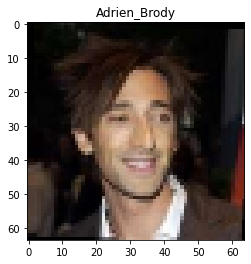

In [ ]:
img_resized = tf.image.resize(img_array, size=[64,64]).numpy() # resizing images to 128x128x3
img_resized = img_resized / 255.0 # normalizing images in the range 0-1
plt.imshow(img_resized[100])
plt.title(class_dict[class_array[100]])

**Splitting dataset into Training and Test sets**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(img_resized, class_array, test_size=0.2, shuffle=False)

In [ ]:
# Dataset has images that repeat only once or twice. So we apply this function to get the list of indices whose classes were repeated more than two times. 
# This makes the NN to learn two different postive pairs instead of learning the same image as positive pair. Hence the 'same image artifact' is removed.  
def keep_more_than_2(dataframe, label_column):
  more_than_2 = []
  unique_classes = label_column.unique()
  for i in unique_classes:
    df_tmp = dataframe.loc[label_column == i]
    index_tmp = df_tmp.index.values
    if len(index_tmp) > 2:
      more_than_2.extend(index_tmp)
  return more_than_2

In [ ]:
# Getting the indices whose classes were repeated more than two times
df_train = pd.DataFrame(data=Y_train, columns=["label"])
mt2_train = df_train.apply(lambda x: keep_more_than_2(df_train, df_train["label"])) # you can also simply use keep_more_than_2(df_train, df_train["label"])

df_test = pd.DataFrame(data=Y_test, columns=["label"])
mt2_test = df_test.apply(lambda x: keep_more_than_2(df_test, df_test["label"]))

In [ ]:
# Getting only those more_than_2 indices and taking the first 4000 and 1000 images from train and test set respectively.
X_train = X_train[mt2_train].squeeze()[:4000]
Y_train = Y_train[mt2_train].squeeze()[:4000]
X_test = X_test[mt2_test].squeeze()[:1000]
Y_test = Y_test[mt2_test].squeeze()[:1000]

In [ ]:
# Shuffling them now. Previously it was not shuffled because number images of same class could be reduced while taking first 1000 images 
X_train, Y_train = shuffle(X_train, Y_train, random_state=10) 
X_test, Y_test = shuffle(X_test, Y_test, random_state=10)

**Make positive and negative image pairs**

In [ ]:
def make_pairs(images, labels):
  """
  Returns pairs of positive and negative image pairs for every image.
  
  Inputs:
  1. images: images in numpy array of shape (n, h, w, c)
  2. labels: labels of the images in numpy array of shape (n,)

  Returns:
  1. np.array(image_pair) - array of shape (n*2, 2, h, w, c) where every sample 
                            now has a positive pair and negative pair
                            You can access two images of a positve/negative pair 
                            by (sample, 0, h, w, c) and (sample, 1, h, w, c)
  2. np.array(label_pair) - array of shape (n*2, ) having 1 for positive pair
                            and 0 for negative pair.
  3. np.array(original_class) - array of shape (n*2, ) having the class integers
                                to which each image belongs
  """


  # initialize three empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative and
  # the actual class number to later check in class dict
  image_pair = []
  label_pair = []
  original_class = []

  # loop over all images  
  for i in range(len(images)):
    for j in range(1): # loop for creating n positive and n negative pairs per example. Can be adjusted according to needs. 1 = 1 positive and negative pair per example
    # grab the current image and it's label
      current_img = images[i]
      current_label = labels[i]
    # get the list of indices where this label is present
      pos_idxs = np.where(labels == current_label)[0]
    # select one random index out of it
      pos_idx = np.random.choice(pos_idxs)
    # use that as a positive image pair
      pos_img = images[pos_idx]
    # append the current & positive image, 1 as an indication for positive pair
    # and current image's original class number in 3 lists
      image_pair.append([current_img, pos_img])
      label_pair.append([1])
      original_class.append(current_label)

    # get the list of indices where this label is NOT present and choose one out of it
      neg_idxs = np.where(labels != current_label)[0]
      neg_idx = np.random.choice(neg_idxs)
    # use that as a negative image pair
      neg_img = images[neg_idx]
    # append the current & negative image, 0 as an indication for negative pair
    # and current image's original class number in 3 lists
      image_pair.append([current_img, neg_img])
      label_pair.append([0])
      original_class.append(current_label)

  return np.array(image_pair), np.array(label_pair), np.array(original_class)   

In [ ]:
# pairTrain and pairtest gets double in size because every example now has a postive and negative pair
pairTrain, labelTrain, classTrain = make_pairs(X_train, Y_train)
pairTest, labelTest, classTest = make_pairs(X_test, Y_test)

In [ ]:
labelTrain = labelTrain.astype("float32")
labelTest = labelTest.astype("float32")

In [ ]:
# Deleting unnecessary variables to free up ram in colab
del img_array, img_resized
del X_train, X_test, Y_train, Y_test

In [ ]:
pairTrain.shape

(8000, 2, 64, 64, 3)

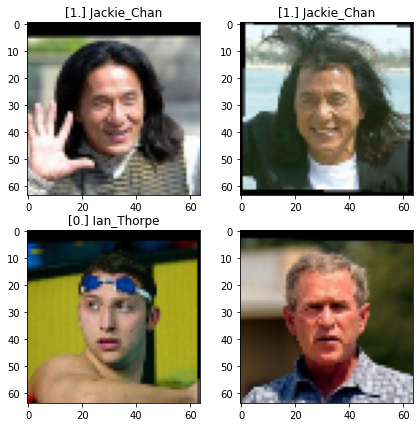

In [ ]:
# View a random positive and negative pair
fig, axs = plt.subplots(2, 2, figsize=(7,7))

pos_idxs = np.where(labelTrain == 1)[0]
pos_idx = np.random.choice(pos_idxs) # get a positive index

neg_idxs = np.where(labelTrain != 1)[0]
neg_idx = np.random.choice(neg_idxs) # get a negative index

# display positive pairs
axs[0,0].imshow(pairTrain[pos_idx][0])
axs[0,0].set_title(str(labelTrain[pos_idx])+ " "+ class_dict[classTrain[pos_idx]])
axs[0,1].imshow(pairTrain[pos_idx][1])
axs[0,1].set_title(str(labelTrain[pos_idx])+ " "+ class_dict[classTrain[pos_idx]])

# display negative pairs
axs[1,0].imshow(pairTrain[neg_idx][0])
axs[1,0].set_title(str(labelTrain[neg_idx])+ " "+ class_dict[classTrain[neg_idx]])
axs[1,1].imshow(pairTrain[neg_idx][1])

**Creating Model**

In [ ]:
def base_model():
  inp = Input(shape=(64, 64, 3), name="base_input")

  x = Conv2D(64, (3,3), padding="valid", activation="relu", kernel_initializer="he_uniform", name="conv_1")(inp)
  x = MaxPool2D(pool_size=(2,2), name="maxpool_1")(x)
  x = Dropout(0.2, name="dropout_1")(x)

  x = Conv2D(64, (3,3), padding="valid", activation="relu", kernel_initializer="he_uniform", name="conv_2")(x)
  x = MaxPool2D(pool_size=(2,2), name="maxpool_2")(x)
  x = Dropout(0.2, name="dropout_2")(x)

  x = Conv2D(128, (3,3), padding="valid", activation="relu", kernel_initializer="he_uniform", name="conv_3")(x)
  x = MaxPool2D(pool_size=(3,3), name="maxpool_3")(x)
  x = Dropout(0.2, name="dropout_3")(x)

  x = GlobalAveragePooling2D(name="gpa_1")(x)
  out = Dense(128, activation="relu", kernel_initializer="he_uniform", name="dense_1")(x)

  return Model(inputs=inp, outputs=out, name="base_model")

def euclidean_distance(vectors_list):
  # Function to calculate the euclidean distance between two twin networks
  # vectors_list = [vector_output_a, vector_output_b]
  x, y = vectors_list
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))  

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
  """
  Explanation of eucl_dist_output_shape. 
  In our case:
  shapes = [vector_output_a, vector_output_b]
  then..
  shape1 = vector_output_a (eg: 8000, 128), shape2 = vector_output_b (eg: 8000, 128)
  shape1[0] = 8000
  returns (8000, 1) --> This means the function lambda should return one value for 8000 examples.
  the output of Lambda should have the shape (8000,1)
  """

In [ ]:
base_network = base_model()
print(base_network.summary())

input_a = Input(shape=(64, 64, 3), name="input_a")
vector_output_a = base_network(input_a)

input_b = Input(shape=(64, 64, 3), name="input_b")
vector_output_b = base_network(input_b)

eucl_output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vector_output_a, vector_output_b])

model = Model(inputs=[input_a, input_b], outputs=eucl_output, name="siamese_model")
print(model.summary())

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 29, 29, 64)        36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0

**Training the Siamese Model**

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
# Needed when you use a custom loss and trying to load a saved model
from keras.utils.generic_utils import get_custom_objects

loss = contrastive_loss_with_margin(margin=1)
get_custom_objects().update({"contrastive_loss": loss})
model = tf.keras.models.load_model("/content/drive/MyDrive/Siamese_Images/Copy of saved-model-95.h5")

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss=contrastive_loss_with_margin(margin=1))

file_path = "/content/drive/MyDrive/Siamese_Images/model_checkpoint/saved-model-{epoch:02d}.h5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_freq="epoch", save_weights_only=False)
history = model.fit([pairTrain[:,0], pairTrain[:,1]], labelTrain, batch_size=128, epochs=100, validation_data=([pairTest[:,0], pairTest[:,1]], labelTest), callbacks=[callback])

**Training and Test Accuracy**

In [ ]:
pred_test = model.predict([pairTest[:,0], pairTest[:,1]])

In [ ]:
pred_test = pred_test.squeeze()
pred_test_2 = pred_test.copy()
pred_test_2[pred_test<0.5] = 1 # If the score is less than 0.5 predict 1
pred_test_2[pred_test>0.5] = 0
labelTest_2 = labelTest.squeeze()
test_acc = np.sum(labelTest_2 == pred_test_2) / 2000

print('Test Accuracy: ' + str(test_acc))

Test Accuracy: 0.755


In [ ]:
pred_train = model.predict([pairTrain[:,0], pairTrain[:,1]])

In [ ]:
pred_train = pred_train.squeeze()
pred_train_2 = pred_train.copy()
pred_train_2[pred_train<0.5] = 1
pred_train_2[pred_train>0.5] = 0
labelTrain_2 = labelTrain.squeeze()
train_acc = np.sum(labelTrain_2 == pred_train_2) / 8000

print('Train Accuracy: ' + str(train_acc))

Train Accuracy: 0.85275


The test and train accuracy could increase if the model was made to run for more epochs. The epochs were limited here because of the time taken for computations.

**Testing the model performance on own images**

In [ ]:
path1 = "/content/drive/MyDrive/Siamese_Images/obama_2.jpeg"
path2 = "/content/drive/MyDrive/Siamese_Images/barack-obama-12782369-1-402.jpg"
path3 = "/content/drive/MyDrive/Siamese_Images/skysports-steven-gerrard-rangers_5269858.jpg"

def test_pair(path1, path2):

  """
  Makes a pair for the the model to predict by taking in two paths of the images.
  Loads the images as numpy array, resizes it, normalizes and makes them a pair.
  Feed into the model as model.predict([pair[:,0], pair[:,1]])
  """
  pair_list = []
  img_1 = plt.imread(path1)
  img_2 = plt.imread(path2)

  img_1 = tf.image.resize(img_1, size=[64,64]).numpy()
  img_2 = tf.image.resize(img_2, size=[64,64]).numpy()

  img_1 = img_1 / 255.0
  img_2 = img_2 / 255.0

  pair_list.append((img_1, img_2))

  return np.array(pair_list)

In [ ]:
pair1 = test_pair(path1, path2)
pair2 = test_pair(path2, path3)

Text(0.5, 1.0, 'Score: 0.5509191')

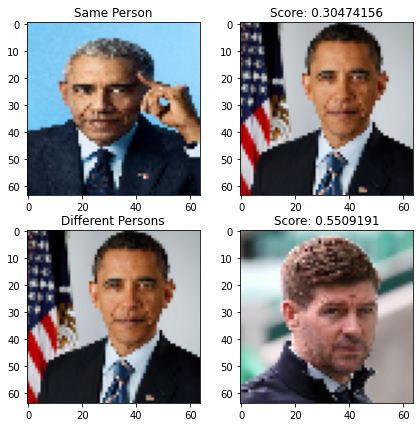

In [ ]:
# View two pairs from own data
fig, axs = plt.subplots(2, 2, figsize=(7,7))


# display pair1
axs[0,0].imshow(pair1[0,0])
same_or_not = ["Same Person" if model.predict([pair1[:,0], pair1[:,1]])[0,0] < 0.50 else "Different Persons"]
axs[0,0].set_title(same_or_not[0])
axs[0,1].imshow(pair1[0,1])
axs[0,1].set_title("Score: " + str(model.predict([pair1[:,0], pair1[:,1]])[0,0]))
# display pair2
axs[1,0].imshow(pair2[0,0])
same_or_not = ["Same Person" if model.predict([pair2[:,0], pair2[:,1]])[0,0] < 0.50 else "Different Persons"]
axs[1,0].set_title(same_or_not[0])
axs[1,1].imshow(pair2[0,1])
axs[1,1].set_title("Score: " + str(model.predict([pair2[:,0], pair2[:,1]])[0,0]))

**References**

The following websites were helpful to get the dataset, prepare the dataset and create the siamese model. 

1. [https://www.kaggle.com/atulanandjha/lfwpeople](https://www.kaggle.com/atulanandjha/lfwpeople)
2. [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/)
3. [https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/](https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/)
4. [https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/](https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/)
5. [https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow](https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow)